# Plots describing hotspot size in Fig 1H

In [1]:
from collections import defaultdict
import os
import json 

import matplotlib
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import pandas as pd
import scipy

In [2]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

In [3]:
# Colors
color_data = {
    'snv' : '#207cb8ff', 
    'mnv' : '#ffdca8ff',
    'ins' : '#5fd38dff',
    'del' : '#f76e6bff'
}

In [4]:
title_muttype_d = {
    'snv': 'SNV hotspots', 
    'mnv': 'MNV hotspots', 
    'ins': 'Insertion hotspots', 
    'del': 'Deletion hotspots'
}

#### Load data

We will use Dataset EV2 and hotspots per cancer type (Zenodo repository)

In [5]:
data_dir = './data'

In [6]:
# Cancer types (we will only use Level A cancer types)
# This input data corresponds to Dataset EV2
ctype_f = os.path.join(data_dir, 'EV2_table.txt')
ctype_df = pd.read_csv(ctype_f, sep='\t', header=0)
level_A = list(ctype_df.loc[ctype_df['LEVEL_ANALYSIS'] == 'A']['CANCER_TYPE'])
level_long = dict(list(zip(ctype_df['CANCER_TYPE'], [i.split(' (')[0] for i in ctype_df['CANCER_TYPE_LONG']])))

In [7]:
# Read hotspots
data = {}    
ctypes_to_analyze = []

for ctype in level_A: 
    # These are output files from HotspotFinder containing hotspots per cancer type
    input_f = os.path.join(data_dir, f'{ctype}.hotspots_n2_altsplit_nodrivers.tsv.gz')
    df = pd.read_csv(input_f, sep='\t', header=0)
    summary_results = defaultdict(dict)
    
    if len(df) > 0: 
        for mutype in ['snv', 'mnv', 'ins', 'del']: 
            mutype_df = df.loc[df['MUT_TYPE'] == mutype].copy()
            mutype_df['ANNOTATION'] = mutype_df['CODING_NONCODING']
            mutype_df['ANNOTATION'] = mutype_df.apply(lambda x: 'IG/TCR' if x['IG_TR_OVERLAP'] else x['ANNOTATION'], axis=1)
            n_samples = mutype_df['N_MUTATED_SAMPLES'].to_list()
            hotspots_ids = mutype_df['HOTSPOT_ID'].to_list()
            ge_region = mutype_df['ANNOTATION'].to_list()
            symbols = mutype_df['SYMBOL'].to_list()   
            info = [f'{i[0]}::{i[1]}::{i[2]}::{i[3]}::{i[4]}' for i in zip(n_samples, [ctype]*len(hotspots_ids), hotspots_ids, ge_region, symbols)]
            
            summary_results[mutype]['n_samples'] = n_samples
            summary_results[mutype]['info'] = info
        
        # Save
        data[ctype] = summary_results    
        print(ctype)
        ctypes_to_analyze.append(ctype)
                        
    else: 
        print(f'Cancer type {ctype} has no hotspots')

ACC
ALL
EPM
HGGNOS
LGGNOS
NBL
Cancer type RBL has no hotspots
AN
BILIARY_TRACT
COADREAD
ES
HEAD_NECK
LIVER
SCLC
PLMESO
GBM
LNET
SBNET
OV
BCC
SKCM
CSCC
SBC
THYROID
BLADDER_URI
CERVIX
VULVA
BRCA
MBL
ODG
PAST
KIDNEY
NSCLC
NHL
AML
MPN
PANCREAS
PROSTATE
ST
UCEC
BONE_SOFT_TISSUE


## Panel 1H 

### Histograms showing hotspot size distribution

In [8]:
def histogram(data_to_plot, mutype, threshold): 
    
    ax.set_xlabel('# samples', fontsize=6)
    ax.set_ylabel('frequency', fontsize=6)
    ax.set_axisbelow(True)

    total_hotspots = len(data_to_plot)
    y = []
    for cutoff in range (2, threshold + 1): 
        if cutoff < threshold: 
            counts = data_to_plot.count(cutoff)
        else: 
            counts = len([i for i in data_to_plot if i >= threshold])
        fraction = counts / total_hotspots
        y.append(fraction)
    x = [i + 2 for i in range(len(y))]
    matplotlib.pyplot.bar(x, y, width=0.9, color=color_data[mutype])
    
    ax.set_xticks([2, 5, cutoff])
    ax.set_xticklabels(['2', '5', f'>={threshold}'], fontsize=5)
    ax.set_yticks([0.25, 0.5, 0.75, 1])
    ax.set_xlim(1, 8)
    ax.set_xticks([2, 4, 6, 8])
    ax.set_xticklabels([2, 4, 6, 8], fontsize=5)
    
    # Plot params
    plt.xticks(rotation=0, fontsize=6)
    plt.yticks(rotation=0, fontsize=6)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
    ax.xaxis.set_tick_params(width=0.5)
    ax.yaxis.set_tick_params(width=0.5)

    plt.title(f'{title_muttype_d[mutype]} (n={total_hotspots})', fontsize=6)

In [9]:
# Generate data for the histograms
data_for_histogram = defaultdict(list)
data_for_dotplot = defaultdict(list)
for ctype, ctype_data in data.items(): 
    if ctype in level_A: 
        for mutype, hotspots_data in ctype_data.items(): 
            data_for_histogram[mutype] += hotspots_data['n_samples']
            data_for_dotplot[mutype] += list(zip(hotspots_data['n_samples'], hotspots_data['info']))

snv
mnv
ins
del


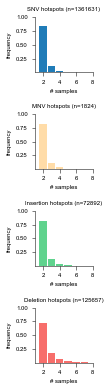

In [10]:
# Plot
fig = plt.figure(figsize=(1, 6))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.75)
threshold = 10
for i, mutype in enumerate(['snv', 'mnv', 'ins', 'del'], 1):
    print(mutype)
    ax = fig.add_subplot(4, 1, i)
    ax = histogram(data_for_histogram[mutype], mutype, threshold)

for extension in ['png']: 
    output = f'./fig_1H_histograms.{extension}'
    plt.savefig(output, bbox_inches='tight', dpi=300)

### Dotplot showing individual hotspot sizes

In [11]:
region_markers = {
    'CODING': ('s', 30),
    'IG/TCR': ('x', 55),
    'NONCODING': ('d', 55),
}

In [12]:
ctype_colors = {
    'NHL': '#1f77b4ff', 
    'SKCM': '#d62728ff', 
    'BRCA': '#aec7e8ff', 
    'COADREAD': '#ffbb78ff', 
    'NSCLC': '#2ca02cff', 
    'PROSTATE': '#ff7f0eff',
    'LIVER': '#98df8aff'
}

In [13]:
mutype_threshold = {
    'snv': 60, 
    'mnv': 10, 
    'ins': 40, 
    'del': 30
}

snv
((78, '78::NHL::22_22881259_snv>A::IG/TCR::None'), 77.99934029200229, 1)
((109, '109::NHL::22_22881259_snv>C::IG/TCR::None'), 108.98401871034422, 1)
mnv
((10, '10::SKCM::3_16264997_mnv>TT::NONCODING::DPH3;OXNAD1'), 9.988500697752539, 0.8563946163161543)
((10, '10::PROSTATE::X_66975839_mnv>GC::NONCODING::None'), 9.979976852317236, 1.5083136842633698)
((11, '11::COADREAD::4_150998842_mnv>ACGGCGACCA::NONCODING::LRBA'), 11.002640098536425, 1)
ins
((48, '48::BRCA::9_33150270_ins>GA::NONCODING::B4GALT1'), 48.00069983897511, 1)
del
((31, '31::LIVER::18_58452573_del>AAG::NONCODING::MIR122HG'), 31.003454156542386, 1)
((35, '35::COADREAD::4_171055952_del>TATCC::NONCODING::LINC02431'), 34.97855244573186, 1)


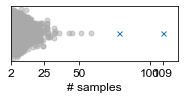

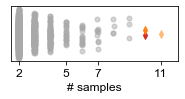

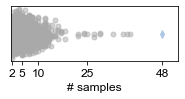

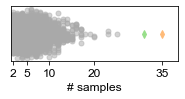

In [14]:
for i, mutype in enumerate(['snv', 'mnv', 'ins', 'del'], 1): 
    
    print(mutype)
    
    fig = plt.figure(figsize=(3, 1))
    ax = plt.subplot2grid((1, 1), (0, 0))
    ax.set_xlabel('# samples', fontsize=12)
    
    
    ## Get the data to plot
    total_hotspots = sorted(data_for_dotplot[mutype], key=lambda x: x[0])
    total_sample_sizes = [i[0] for i in total_hotspots]
    
    ctypes = set()
    for n_samples in sorted(list(set(total_sample_sizes))):     # iterate over x (number of samples) 
        n_hotspots = total_sample_sizes.count(n_samples)
        info_hotspots = [i for i in total_hotspots if i[0] == n_samples]
        
        # Subsample hotspots to generate less dots in the plot 
        # This helps in those sample sizes with too many dots (eases computation)
        if n_hotspots > 1000: 
            indexes = np.random.choice(n_hotspots, 1000)
            info_hotspots = np.array(total_hotspots)[indexes]
            n_hotspots = 1000
        
        # Add dispersion to show dots over y axis
        x_dispersion = list(np.random.normal(n_samples, 0.01, size=n_hotspots))
        if n_hotspots > 1: 
            y_dispersion = list(np.random.normal(1, 1-1/n_hotspots, size=n_hotspots))
        else:
            y_dispersion = [1] * n_hotspots     
            
        
        # Print info to annotate the final figure
        if n_samples >= mutype_threshold[mutype]: 
            for h in list(zip(info_hotspots, x_dispersion, y_dispersion)): 
                color = ctype_colors[h[0][1].split('::')[1]]
                marker = region_markers[h[0][1].split('::')[-2]][0]
                plt.plot(h[1], h[2], marker, markersize=5, linewidth=3, color=color, alpha=1, zorder=3)
                print(h)
                ctypes.add(h[0][1].split('::')[1])
        else:     
            plt.plot(x_dispersion, y_dispersion, '.', markersize=10, linewidth=0, color='darkgrey', alpha=0.5, zorder=0)
    
    
    # Plot params
    ax.set_yticks([])
    xticks = {
        'snv': [2, 25, 50, 100, 150, max(total_sample_sizes)], 
        'mnv': [2, 5, 7, max(total_sample_sizes)], 
        'ins': [2, 5, 10, 25, max(total_sample_sizes)], 
        'del': [2, 5, 10, 20, max(total_sample_sizes)], 
    }
    ax.set_xticks(xticks[mutype])
    right_margin = max(total_sample_sizes) + max(total_sample_sizes)/10
    ax.set_xlim(xmin=2-0.5, xmax=right_margin)
    for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(12) 

    for extension in ['png']: 
        output = f'./fig_1H_dotplot_{mutype}.{extension}'
        plt.savefig(output, bbox_inches='tight', dpi=300)